# Teaching Physics to an AI

In this Notebook, I will run simple physics simulations, and then show how neural networks can be used to "learn" or predict future states in the simulation.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%config InlineBackend.figure_format = 'retina'

## Spring Harmonic Oscillator

$$
F = ma = -kx
$$

with the initial conditions of $x(0) = 1$ and $v(0) = x^\prime(0) = 0$.


### Computational Solution

Writing this as an ODE:
$$
x^{\prime\prime} = -\frac{k}{m}x
$$

Scipy's ODE solver can solve any system of first order ODEs, so we will rewrite this 2nd-order ODE as a system of first-order ODEs:
$$
\begin{align}
x_1^\prime &= x_2 \\
x_2^\prime &= -\frac{k}{m}x_1
\end{align}
$$

Now let's code this up in Python.

In [2]:
def spring_odes(X, t, k, m):
    x1, x2 = X[0], X[1]
    dx1dt = x2
    dx2dt = -k/m*x1
    return [dx1dt, dx2dt]

In [3]:
X0 = [1, 0]  # initial conditions
t = np.linspace(0, 10, 100)

k = 1  # spring constant
m = 1  # mass

sol = odeint(spring_odes, X0, t, args=(k, m))

# sol contains the solution for x1 and x2, i.e. the position and the velocity

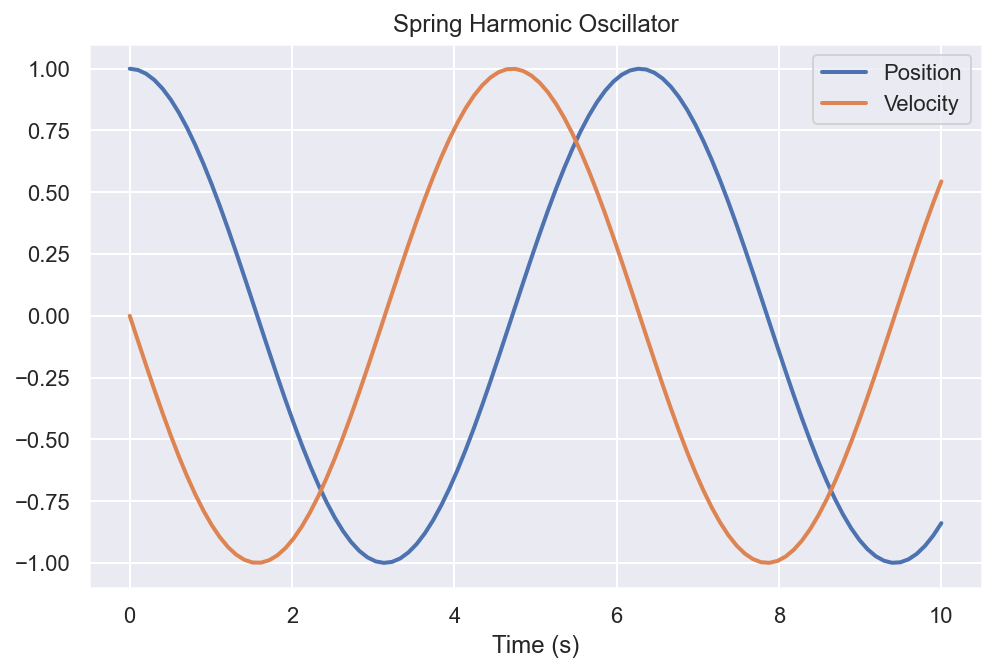

In [4]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t, sol[:,0], lw=2)
ax.plot(t, sol[:,1], lw=2)
ax.set_xlabel('Time (s)')
ax.set_title('Spring Harmonic Oscillator')
ax.legend(['Position', 'Velocity'])

### Neural Network Prediction

Now let's show a neural network part of the data from this harmonic oscillator and have it try to predict the rest.

In [5]:
import pandas as pd

x = sol[:,0]
v = sol[:,1]
a = -k/m * x

data = pd.DataFrame()
data['t'] = t
data['x'] = x
data['v'] = v
data['a'] = a

In [6]:
data.head()

,t,x,v,a
0,0.00000,1.000000,0.000000,-1.000000
1,0.10101,0.994903,-0.100838,-0.994903
2,0.20202,0.979663,-0.200649,-0.979663
3,0.30303,0.954437,-0.298414,-0.954437
4,0.40404,0.919480,-0.393137,-0.919480


Now add a column containing the spring mass position at time $t+1$:

In [7]:
# drop the last row in `data`
data = data.drop(data.index[-1])

x_next = x[1:]
data['next'] = x_next

In [8]:
X = data[['x', 'v', 'a']].values
y = data['next'].values

# Split the data into training and test data
split_frac = 0.5
split = int(split_frac * len(data))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [9]:
from sklearn.neural_network import MLPRegressor

In [10]:
regr = MLPRegressor(hidden_layer_sizes=(100,),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=1)

regr.fit(X_train, y_train)

MLPRegressor(max_iter=500, random_state=1)

In [11]:
y_pred = regr.predict(X_test)

regr.score(X_test, y_test)

0.9959791495085959

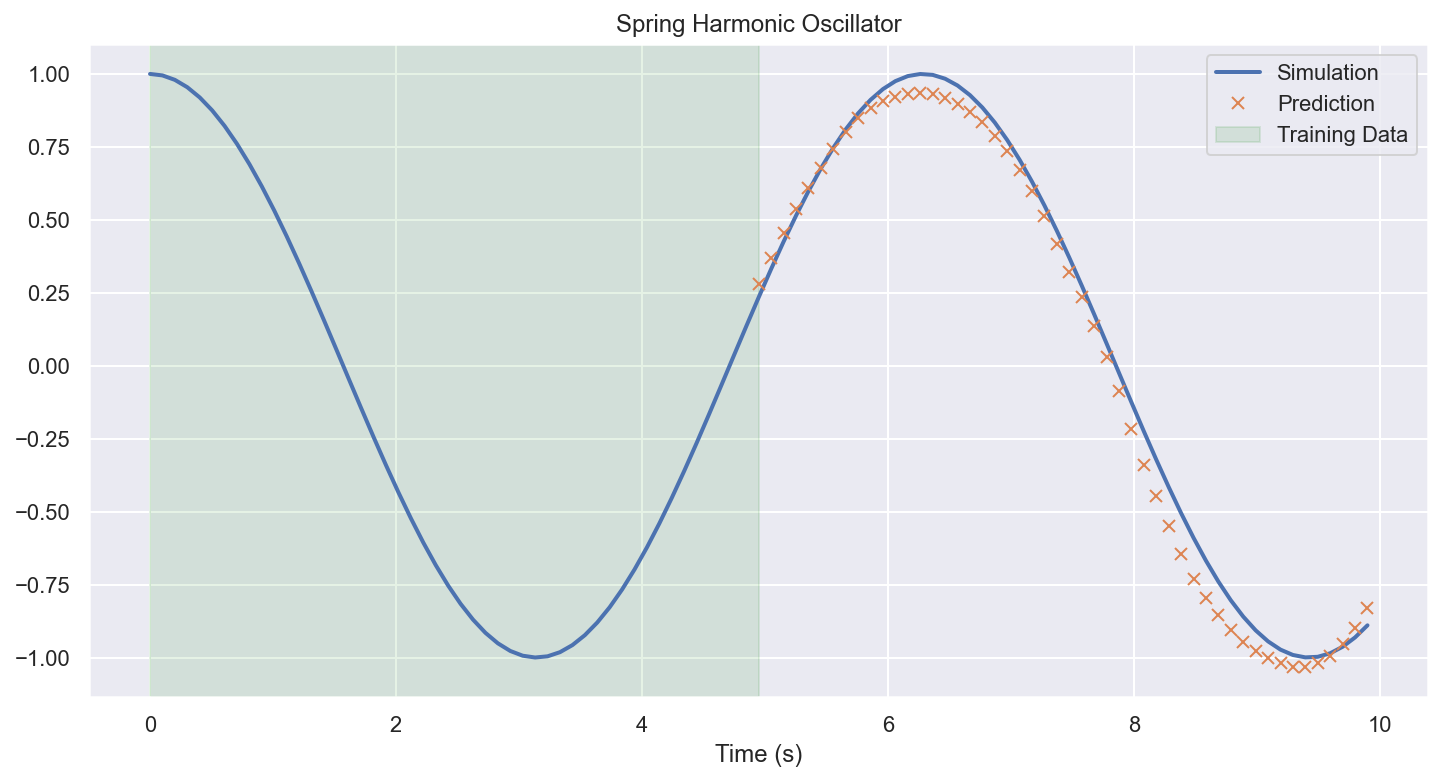

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

t = data['t']
x = data['x']

ax.plot(t, x, lw=2)
ax.plot(t[split:], y_pred, 'x', lw=2)
ax.axvspan(0, t[split], alpha=0.1, color='green')
ax.set_xlabel('Time (s)')
ax.set_title('Spring Harmonic Oscillator')
ax.legend(['Simulation', 'Prediction', 'Training Data'])

#### Try again with more data

In [37]:
X0 = [1, 0]  # initial conditions
t = np.linspace(0, 20, 1000)

k = 1  # spring constant
m = 1  # mass

sol = odeint(spring_odes, X0, t, args=(k, m))

x = sol[:,0]
v = sol[:,1]
a = -k/m * x

data = pd.DataFrame()
data['t'] = t
data['x'] = x
data['v'] = v
data['a'] = a

data = data.drop(data.index[-1])

x_next = x[1:]
data['next'] = x_next

X = data[['x', 'v', 'a']].values
y = data['next'].values

# Split the data into training and test data
split_frac = 0.75
split = int(split_frac * len(data))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

regr = MLPRegressor(hidden_layer_sizes=(500,),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=1)

regr.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(500,), max_iter=500, random_state=1)

In [38]:
y_pred = regr.predict(X_test)

regr.score(X_test, y_test)

0.9999063927201782

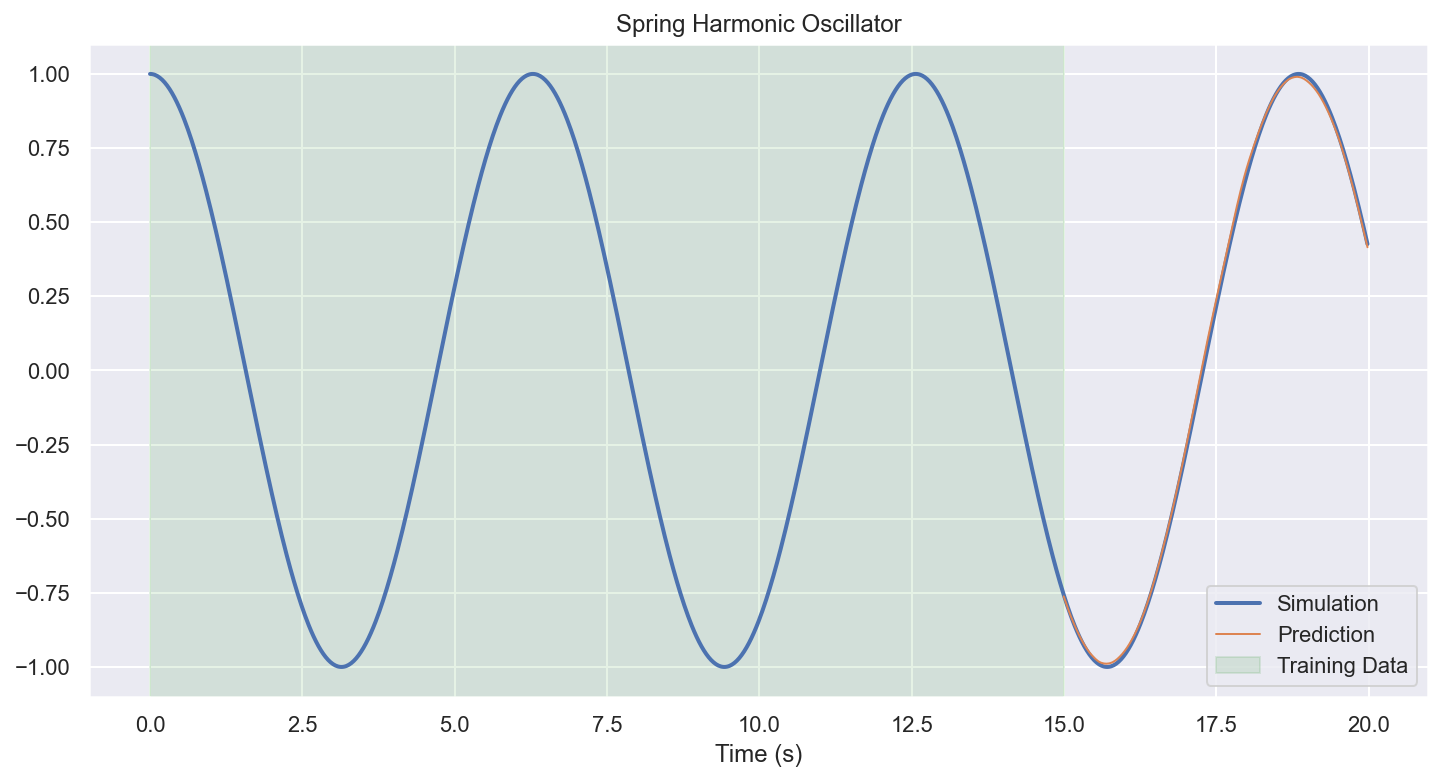

In [39]:
fig, ax = plt.subplots(figsize=(12,6))

t = data['t']
x = data['x']

ax.plot(t, x, lw=2)
ax.plot(t[split:], y_pred, lw=1)
ax.axvspan(0, t[split], alpha=0.1, color='green')
ax.set_xlabel('Time (s)')
ax.set_title('Spring Harmonic Oscillator')
ax.legend(['Simulation', 'Prediction', 'Training Data'])

### Caveats

This neural network is very simple. It may not be able to project very far into the future with high accuracy. It likely won't generalize to other values for the mass or spring constant. Our example is a simple harmonic oscillator, with no friction or other dissipative forces. It will continue to oscillate forever with the same period and amplitude. In order to generalize to more complex physics, the neural network will likely also need to be more complex. DeepMind used a graph network architecture.